# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2020/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

*If you fail to follow these simple instructions, it will negatively impact your grade!*

**Due date and time**: The assignment is due on Tuesday November 3rd at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/.

### Overview

This year's Assignment 2 is all about analyzing the network of superheroes from the Marvel and DC universes. 

Note that this time, I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaning fully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----






**Exercise 1**: Visualize the network (from lecture 5) and calculate basic stats (from lecture 4). For this exercise, we assume that you've already generated the network of superheroes, report work on the giant connected component.

Here's what you need to do:

*Exercise 1a*: Stats (see lecture 4 for more hints)
* What is the number of nodes in the network?
* What is the number of links?
* What is the number of links connecting Marvel and DC? Explain in your own words what those links mean?
* Who are top 5 most connected characters? (Report results for in-degrees and out-degrees). Comment on your findings. Is this what you would have expected.
* Plot the in and out-degree distributions. 
  * Explain what you observe? 
  * Explain why the in-degree distribution is different from the out-degree distribution?
* Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$. Comment or your results.

*Exercise 1b*: Visualization (see lecture 5 for more hints)

* Create a nice visualization of the total network.
  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm

In [52]:
import re
import math
import pandas as pd
import networkx as nx
import collections
import matplotlib.pyplot as plt
import numpy as np
import random
from fa2 import ForceAtlas2
from nltk import word_tokenize
from wordcloud import WordCloud

In [2]:
dcUrl = '../files/dc_characters.csv'
marvelUrl = '../files/marvel_characters.csv'
dcNames = pd.read_csv(dcUrl, delimiter='|')
marvelNames = pd.read_csv(marvelUrl, delimiter='|')

In [36]:
dcs = set(dcNames['CharacterName'])
marvels = set(marvelNames['CharacterName'])

In [6]:
DG = nx.DiGraph()

def getNeighbors(text):
    pattern = '\[\[(.*?)\]\]'
    rv = []
    for gp in re.findall(pattern, text):
        if gp in dcs or gp.split('|')[0] in dcs:
            rv.append((gp, 'DC'))
        elif gp in marvels or gp.split('|')[0] in marvels:
            rv.append((gp, 'Marvel'))
        
    return rv

for name in dcs:
    name = str(name)
    DG.add_node(name, universe="DC")
    try:
        with open('../lectures/data/DC/' + name, 'r') as f:
            text = f.read()
            neighbors = getNeighbors(text)
            for n in neighbors:
                DG.add_node(n[0], universe=n[1])
                DG.add_edge(name, n[0])
    except FileNotFoundError as e:
        pass

for name in marvels:
    name = str(name)
    DG.add_node(name, universe="Marvel")
    try:
        with open('../lectures/data/Marvel/' + name, 'r') as f:
            text = f.read()
            neighbors = getNeighbors(text)
            for n in neighbors:
                DG.add_node(n[0], universe=n[1])
                DG.add_edge(name, n[0])
    except FileNotFoundError as e:
        pass

# remove nodes with zero in and out degree
rmNodes = []
for node in DG.nodes:
    if DG.degree(node) == 0:
        rmNodes.append(node)

for node in rmNodes:
    DG.remove_node(node)

## Exercise 1a: Stats

## What is the number of nodes in the network?

In [9]:
print("Number of nodes ", len(DG.nodes))

Number of nodes  3185


## What is the number of links?

In [8]:
print("Number of links ", len(DG.edges))

Number of links  17343


## What is the number of links connecting Marvel and DC? Explain in your own words what those links mean?

In [10]:
DCMavelConCount = 0
for link in DG.edges:
    node1, node2 = link
    if DG.nodes[node1]['universe'] == 'DC' and DG.nodes[node2]['universe'] == 'Marvel':
        DCMavelConCount += 1
    elif DG.nodes[node2]['universe'] == 'DC' and DG.nodes[node1]['universe'] == 'Marvel':
        DCMavelConCount += 1

print("Links between DC and Marvel ", DCMavelConCount)

Links between DC and Marvel  925


**Answer**

The number of links between DC and Marvel universe is 925, this means that the number of citations from charactor pages in DC universe to Marvel universe as well as from Marvel universe to DC universe is 925.

## Who are top 5 most connected characters? (Report results for in-degrees and out-degrees). Comment on your findings. Is this what you would have expected.

In [11]:
in_degree_nodes = [(n, d) for n, d in DG.in_degree()]
in_degree_nodes = sorted(in_degree_nodes, key=lambda x: x[1], reverse=True)
out_degree_nodes = [(n, d) for n, d in DG.out_degree()]
out_degree_nodes = sorted(out_degree_nodes, key=lambda x: x[1], reverse=True)

In [12]:
print("Top 5 based on in_degree ", ','.join([item[0] for item in in_degree_nodes[:5]]))
print("Top 5 based on out_degree ", ','.join([item[0] for item in out_degree_nodes[:5]]))

Top 5 based on in_degree  Spider-Man,Captain America,Iron Man,Hulk,Batman
Top 5 based on out_degree  Jackal,Beast,Belthera, Queen,Brainiac 13,Venom


**Answer**

From the results we can see that the top 5 charactors based on in_degree are those pretty famous like Spider-Man, Superman, Batman and so on which make sence, since they are famous so they have a higher chance to be mentioned. On the other hand, the top 5 charactors based on out_degree are not quite famous. For the reason could be that they require more explanation on the page to make people understand who they are.

## Plot the in and out-degree distributions.

   * Explain what you observe?
   * Explain why the in-degree distribution is different from the out-degree distribution?


In [13]:
in_degree_sequence = sorted([d for n, d in DG.in_degree()], reverse=True)
out_degree_sequence = sorted([d for n, d in DG.out_degree()], reverse=True)

In [20]:
def plotDegree(degree_sequence, label=''):
    counter = collections.Counter(degree_sequence)
    x, y = [], []
    for key, value in counter.items():
        x.append(key)
        y.append(value)

    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("in/out degree distributions")
    plt.plot(x, y, 'o', label=label)

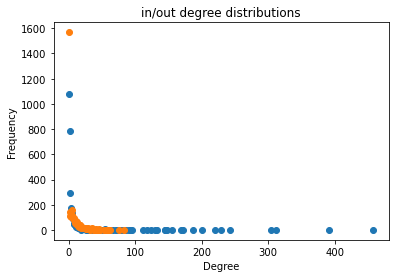

In [21]:
plotDegree(in_degree_sequence, label='in_degree')
plotDegree(out_degree_sequence, label='out_degree')

**Answer**

* From the plot, the in-degree and out-degree of most of the nodes are within 200. Additionally, compare to out-degree, in-degree has a longer tail on x coordinate which means more nodes have a larger in degree compare to out degree. 
* As mentioned above, more nodes have a larger in degree compare to out degree that resulting in the difference in the plot. the reason of this is that for famous charactors they might be cited by almost every characor within the same universe and even from other univers, so the in-degree could add up to a really large number. However, a general wiki page of a charactor can only contain certain amount of text, so the out-degree won't be too large. 

## Compare the degree distribution to a random network with the same number of nodes and probability of connection 𝑝. Comment on your results.

In [22]:
degree_sequence = sorted([d for n, d in DG.degree()], reverse=True)

def logPlot(degree_sequence):
    counter = collections.Counter(degree_sequence)
    x, y = [], []
    for key, value in counter.items():
        x.append(key)
        y.append(value)

    plt.title('Degree Distribution(Log-Log)')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.loglog(x, y, 'o')


def histPlot(degree_sequence):
    vec = [i for i in range(min(degree_sequence), max(degree_sequence) + 1)]
    hx, hy, _ = plt.hist(degree_sequence, bins=vec)
    plt.bar(hy[:-1], hx)
    plt.title('Histogram of the degree distribution')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")

### degree distribution of super heros

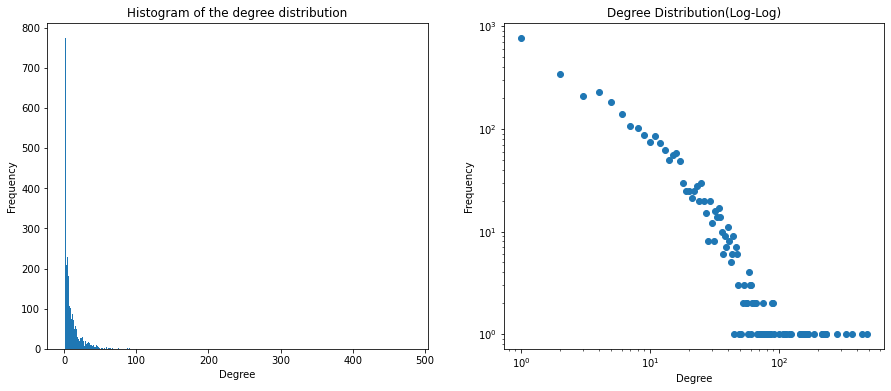

In [23]:
f = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
histPlot(degree_sequence)
plt.subplot(1,2,2)
logPlot(degree_sequence)
plt.show()

In [24]:
N = len(DG.nodes)
k = sum(degree_sequence) / N
p = k / (N - 1)

randomG = nx.generators.random_graphs.erdos_renyi_graph(N, p)
random_degree_sequence = sorted([d for n, d in randomG.degree()], reverse=True)

### degree distribution of corresponding random network

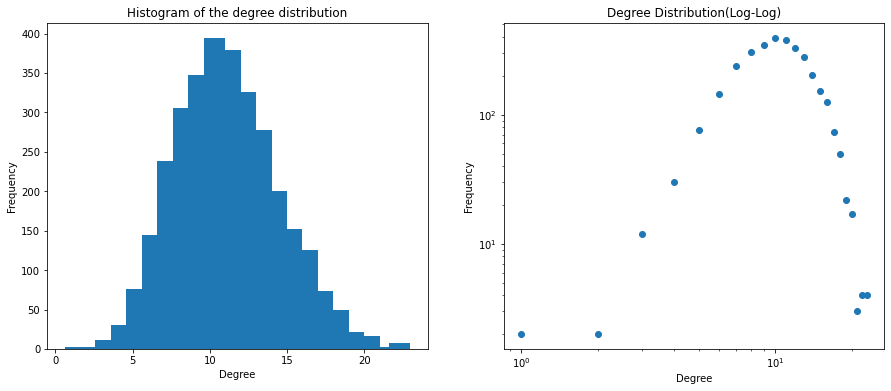

In [25]:
f = plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
histPlot(random_degree_sequence)
plt.subplot(1,2,2)
logPlot(random_degree_sequence)
plt.show()

**Answer**

From the plot, we can see that the super heros network are more like a Scale-free network rather than a random network.

In the histogram degree plot of super heros, the values are gathered within 50, while in the histogram of random network, the degree distribution forms a clear uniform distribution.

## Exercise 1b: Visualization

Create a nice visualization of the total network.

   * Color nodes according to universe
   * Scale node-size according to degree
   * Whatever else you feel like.
   * If you can get it to work, get node positions based on the Force Atlas 2 algorithm


In [27]:
largest_cc = max(nx.algorithms.components.weakly_connected_components(DG), key=len)

In [26]:
def createSubGraph(G, largest_wcc):
    # Create a subgraph SG based on a (possibly multigraph) G
    SG = G.__class__()
    SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)
    if SG.is_multigraph():
        SG.add_edges_from((n, nbr, key, d)
            for n, nbrs in G.adj.items() if n in largest_wcc
            for nbr, keydict in nbrs.items() if nbr in largest_wcc
            for key, d in keydict.items())
    else:
        SG.add_edges_from((n, nbr, d)
            for n, nbrs in G.adj.items() if n in largest_wcc
            for nbr, d in nbrs.items() if nbr in largest_wcc)
    SG.graph.update(G.graph)
    return SG

In [29]:
subDG = createSubGraph(DG, largest_cc)

In [30]:
G = subDG.to_undirected()

In [58]:
colorParm = []
node_sizes = []
degree_dict = {n: d for n, d in G.degree()}
for node in G.nodes():
    if G.nodes[node]['universe'] == "DC":
        colorParm.append("#000000")
    else:
        colorParm.append("#ff0000")
    node_sizes.append(degree_dict[node])

100%|██████████| 1000/1000 [01:46<00:00,  9.39it/s]


BarnesHut Approximation  took  27.51  seconds
Repulsion forces  took  75.91  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.77  seconds
AdjustSpeedAndApplyForces step  took  0.71  seconds


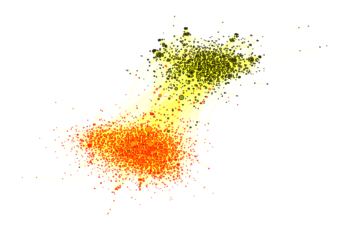

In [61]:
forceatlas2 = ForceAtlas2(# Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.5,
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=True,
                          gravity=1,
                          # Log
                          verbose=True)

new_node_sizes = [x * 0.1 for x in node_sizes]
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)
nx.draw_networkx_nodes(G, positions, node_size=new_node_sizes, node_color=colorParm, alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="yellow", alpha=0.05)
plt.axis('off')
plt.show()

**Exercise 2**: Create your own version of the TF-TR word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the wiki-pages.

Here's what you need to do:

* That's it, really. The title says it all. Create your own version of the TF-TR word-clouds. Explain your process and comment on your results.

#### Tokenize each document in the universes and create two lists that contains all the tokens

In [45]:
DcList, MarvelList = [], []

for name in dcs:
    name = str(name)
    try:
        with open('../lectures/data/clean_DC/' + name, 'r') as f:
            text = f.read()
            tokens = word_tokenize(text)
            tmp = [word.lower() for word in tokens if word.isalpha()]
            DcList.extend(tmp)
    except FileNotFoundError as e:
        pass

    
for name in marvels:
    name = str(name)
    try:
        with open('../lectures/data/clean_Marvel/' + name, 'r') as f:
            text = f.read()
            tokens = word_tokenize(text)
            tmp = [word.lower() for word in tokens if word.isalpha()]
            MarvelList.extend(tmp)
    except FileNotFoundError as e:
        pass

#### Create two dictionary using the token from previous step as keys and the count of occurance as values

In [46]:
marvelDict, dcDict = collections.Counter(MarvelList), collections.Counter(DcList)

#### Using the count of occurance and the formula provided in the lecture notebook to calculate the TF, TR term

In [47]:
def getTF(word, universe):
    if universe == 'Marvel':
        return marvelDict[word] if word in marvelDict else 0
    else:
        return dcDict[word] if word in dcDict else 0

def getWeight(word, universe):
    if universe == "Marvel":
        return getTF(word, "Marvel") * (getTF(word, "Marvel") / (getTF(word, "Dc") + 5))
    else:
        return getTF(word, "Dc") * (getTF(word, "Dc") / (getTF(word, "Marvel") + 5))

In [48]:
marvelTFTR = sorted([(word, getWeight(word, 'Marvel')) for word in marvelDict.keys()], key=lambda x: x[1], reverse=True)
dcTFTR = sorted([(word, getWeight(word, 'DC')) for word in dcDict.keys()], key=lambda x: x[1], reverse=True)

#### Build the text from the TF TR result and plot the word cloud

In [54]:
def getLongText(lst):
    text = ''
    for key, val in lst:
        text += (key + ' ') * math.ceil(val)
    return text

def plotWordCloud(text):
    wordcloud = WordCloud(collocations=False).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Word Cloud for Marvel

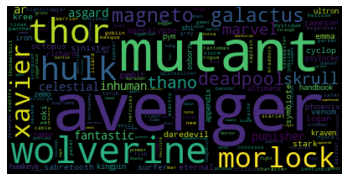

In [55]:
plotWordCloud(getLongText(marvelTFTR))

#### Word Cloud for DC

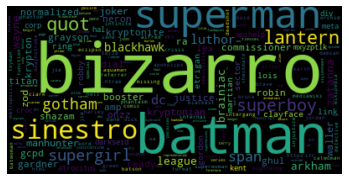

In [56]:
plotWordCloud(getLongText(dcTFTR))

The size of the words in the plot represents the importance of the word. Base on the plot, the most important or most mentioned word in Marvel univese is avenger and bizarro in DC universe. Several famous names are also shown up there like Superman, batman, thor, hulk and so on.

**Exercise 3**: Find communities and create associated TF-IDF word clouds (from lecture 7 and 8). In this exercise, we assume that you have been able to find communities in your network. It's OK to only work on a single universe in this one.

Here's what you need to do:
* Explain briefly how you chose to identify the communities: Which algorithm did you use, how does it work?
* How many communities did you find in total?
* Plot the distribution of community sizes.
* For the 5-10 largest communities, create TF-IDF based rankings of words in each community. There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
* Create a word-cloud displaying the most important words in each community (according to TF-IDF). Comment on your results (do they make sense according to what you know about the superhero characters in those communities?)

**Exercise 4**: Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities. Unlike above - we work all communities. It's still OK to work with data from a single universe. More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below;
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do:
* Calculate and store sentiment for every single page. 
* Create a histogram of all character's associated page-sentiments.
* What are the 10 characters with happiest and saddest pages?
* What are the three happiest communities?
* what are the three saddest communities?
* Do these results confirm what you can learn about each community by skimming the wikipedia pages?